In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
np.random.seed(1) #ensure reproducibility

pd.options.mode.chained_assignment = None 

In [2]:
import dame_flame
import random

## Data Cleaning (CREATING flame_enrollment.csv)

In [ ]:
# We start with a dataset that has registry data merged with unequal commute features data (LIFT_registry_UCMerged)

In [3]:
# After rebinning UC covariates
LIFT_reg = pd.read_csv("/Users/JennyH/cisil-causal-inference/Data/LIFT_registry_UCMerged_new.csv")
LIFT_reg

,Unnamed: 0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial Load,Study Card,...,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q
0,0,40,Asian,English,8/31/2023,2021-09-28,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
1,1,51,Black or African American,English,8/31/2023,2021-10-19,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
2,2,42,Black or African American,English,4/30/2023,2021-04-29,HS Jail Health Services BA6586,530330092002,NaN,NaN,...,3,3,3,3,2,8,8,9,9,5
3,3,59,Black or African American,English,8/31/2023,2021-11-23,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
4,4,44,Hispanic or Latino,English,8/31/2023,2021-11-10,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,93655,36,Asian,English,2/28/2021,2018-05-15,King County Public Health,530330322122,NaN,NaN,...,0,0,0,0,0,1,0,1,1,2
93656,93656,36,Other,English,2/28/2021,2018-05-15,King County Public Health,530330322122,NaN,NaN,...,0,0,0,0,0,1,0,1,1,2
93657,93657,26,Multi-Racial,English,7/31/2020,2018-06-11,CCS BA3628,530330322122,Monthly Pass,NaN,...,0,0,0,0,0,1,0,1,1,2
93658,93658,58,White,English,3/31/2020,2018-06-13,King County Public Health,530530724083,NaN,NaN,...,1,0,0,1,1,3,1,1,2,2


In [5]:
LIFT_reg.columns = [c.replace(' ', '_') for c in LIFT_reg.columns]

In [6]:
# type(LIFT_reg.DateIssued[1])
LIFT_reg['DateIssued'] = pd.to_datetime(LIFT_reg['DateIssued'])
# LIFT_reg['Expiration'] = pd.to_datetime(LIFT_reg['Expiration'])

In [7]:
# After filtering for dates between 2020-10-01 and 2021-04-01, 0.08 of the data remain.
sap = LIFT_¯reg[(LIFT_reg.DateIssued >= "2020-10-01") & (LIFT_reg.DateIssued < "2021-04-01")]

In [8]:
sap["SAP"] = np.where(sap["Initial_Load"] == "Subsidized Annual Pass", 1, 0)
sap

,Unnamed:_0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial_Load,Study_Card,...,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP
0,0,40,Asian,English,8/31/2023,2021-09-28,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,2,8,8,9,9,5,1
1,1,51,Black or African American,English,8/31/2023,2021-10-19,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,2,8,8,9,9,5,1
2,2,42,Black or African American,English,4/30/2023,2021-04-29,HS Jail Health Services BA6586,530330092002,NaN,NaN,...,3,3,3,2,8,8,9,9,5,0
3,3,59,Black or African American,English,8/31/2023,2021-11-23,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,2,8,8,9,9,5,1
4,4,44,Hispanic or Latino,English,8/31/2023,2021-11-10,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,2,8,8,9,9,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,93559,22,Black or African American,English,12/31/2022,2020-10-27,King County Public Health,530330220034,NaN,NaN,...,0,0,0,0,5,0,1,0,0,0
93563,93563,36,White,English,5/31/2023,2020-10-28,KCMCCS,530610526071,10,NaN,...,2,0,0,3,0,7,0,1,8,0
93572,93572,63,White,English,5/31/2023,2020-10-22,DSHS - ORCA LIFT (remote enrollment),530530730053,10,NaN,...,0,0,0,1,0,0,1,2,4,0
93598,93598,52,White,English,4/30/2023,2020-10-03,CCS,530330321021,10,NaN,...,0,0,0,1,0,1,1,2,3,0


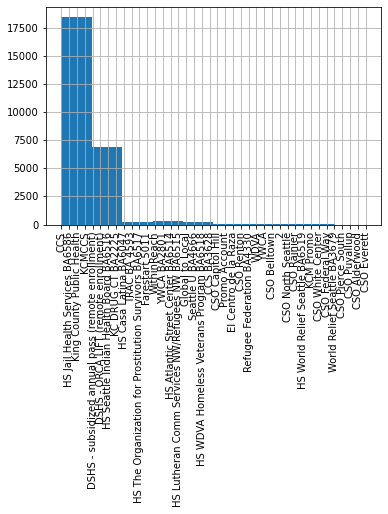

In [68]:
sap["CardIssuingAgency"].hist()
plt.xticks(rotation=90)
plt.show()

In [9]:
top5 = sap.value_counts("CardIssuingAgency").index[:5]
top5.tolist()

['King County Public Health',
 'DSHS - ORCA LIFT (remote enrollment)',
 'DSHS - subsidized annual pass (remote enrollment)',
 'CCS',
 'KCMCCS']

In [10]:
# Condense CardIssuingAgency to the top 5 agencies and and "other" category
sap['Agency'] = (sap.CardIssuingAgency.
                          apply(lambda x: x 
                                if x in top5 
                                else "Other"))
sap

,Unnamed:_0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial_Load,Study_Card,...,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency
0,0,40,Asian,English,8/31/2023,2021-09-28,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,2,8,8,9,9,5,1,CCS
1,1,51,Black or African American,English,8/31/2023,2021-10-19,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,2,8,8,9,9,5,1,CCS
2,2,42,Black or African American,English,4/30/2023,2021-04-29,HS Jail Health Services BA6586,530330092002,NaN,NaN,...,3,3,2,8,8,9,9,5,0,Other
3,3,59,Black or African American,English,8/31/2023,2021-11-23,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,3,2,8,8,9,9,5,1,King County Public Health
4,4,44,Hispanic or Latino,English,8/31/2023,2021-11-10,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,2,8,8,9,9,5,1,CCS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,93559,22,Black or African American,English,12/31/2022,2020-10-27,King County Public Health,530330220034,NaN,NaN,...,0,0,0,5,0,1,0,0,0,King County Public Health
93563,93563,36,White,English,5/31/2023,2020-10-28,KCMCCS,530610526071,10,NaN,...,0,0,3,0,7,0,1,8,0,KCMCCS
93572,93572,63,White,English,5/31/2023,2020-10-22,DSHS - ORCA LIFT (remote enrollment),530530730053,10,NaN,...,0,0,1,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment)
93598,93598,52,White,English,4/30/2023,2020-10-03,CCS,530330321021,10,NaN,...,0,0,1,0,1,1,2,3,0,CCS


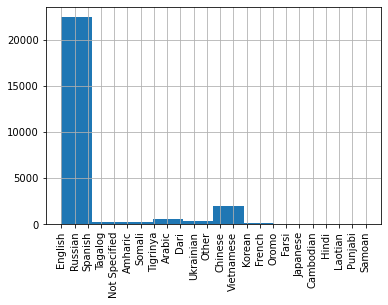

In [71]:
sap["LanguageSpoken"].hist()
plt.xticks(rotation=90)
plt.show()

In [11]:
sap["LanguageSpoken"].value_counts()

English          20754
Chinese           1631
Spanish           1499
Dari               402
Other              353
Vietnamese         310
Amharic            184
Not Specified      177
Russian            164
Tigrinya           124
Somali              73
Farsi               65
Korean              57
Ukrainian           52
French              46
Arabic              46
Tagalog             37
Oromo               13
Cambodian           12
Punjabi             12
Japanese             6
Hindi                5
Samoan               3
Laotian              3
Name: LanguageSpoken, dtype: int64

In [12]:
top5 = sap.value_counts("LanguageSpoken").index[:5]
top5.tolist()

['English', 'Chinese', 'Spanish', 'Dari', 'Other']

In [13]:
# Language is the condensed version of LanguageSpoken.
sap['Language'] = (sap.LanguageSpoken.
                          apply(lambda x: x 
                                if x in top5 
                                else "Other"))
sap

,Unnamed:_0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial_Load,Study_Card,...,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language
0,0,40,Asian,English,8/31/2023,2021-09-28,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,2,8,8,9,9,5,1,CCS,English
1,1,51,Black or African American,English,8/31/2023,2021-10-19,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,2,8,8,9,9,5,1,CCS,English
2,2,42,Black or African American,English,4/30/2023,2021-04-29,HS Jail Health Services BA6586,530330092002,NaN,NaN,...,3,2,8,8,9,9,5,0,Other,English
3,3,59,Black or African American,English,8/31/2023,2021-11-23,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,2,8,8,9,9,5,1,King County Public Health,English
4,4,44,Hispanic or Latino,English,8/31/2023,2021-11-10,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,2,8,8,9,9,5,1,CCS,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,93559,22,Black or African American,English,12/31/2022,2020-10-27,King County Public Health,530330220034,NaN,NaN,...,0,0,5,0,1,0,0,0,King County Public Health,English
93563,93563,36,White,English,5/31/2023,2020-10-28,KCMCCS,530610526071,10,NaN,...,0,3,0,7,0,1,8,0,KCMCCS,English
93572,93572,63,White,English,5/31/2023,2020-10-22,DSHS - ORCA LIFT (remote enrollment),530530730053,10,NaN,...,0,1,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English
93598,93598,52,White,English,4/30/2023,2020-10-03,CCS,530330321021,10,NaN,...,0,1,0,1,1,2,3,0,CCS,English


In [14]:
# split into user id and card number
sap[['user_id', 'stage']] = sap['card_id'].str.split('-', expand=True)

In [15]:
# bin age.
sap['Age_bin']=pd.cut(x = sap['Age'],
                        bins = [0,25,35,45,55,65,200], 
                        labels = [0,1,2,3,4,5])

# sap.drop(columns=['RaceDesc','LanguageSpoken', 'CardIssuingAgency'],inplace=True)

In [16]:
sap = sap.loc[:, ~sap.columns.isin(['Study_Card', 'card_id','DateIssued','GEOID','Unnamed:_0','Expiration','LanguageSpoken','Age','CardIssuingAgency'])]
sap

,RaceDesc,FIPS,Initial_Load,duplicate,stage,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin
0,Asian,530330092002,Subsidized Annual Pass,False,8,61080,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,1,CCS,English,61080,2
1,Black or African American,530330092002,Subsidized Annual Pass,False,6,107444,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,1,CCS,English,107444,3
2,Black or African American,530330092002,NaN,False,6,57528,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,0,Other,English,57528,2
3,Black or African American,530330092002,Subsidized Annual Pass,False,5,10168,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,1,King County Public Health,English,10168,4
4,Hispanic or Latino,530330092002,Subsidized Annual Pass,False,5,172698,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,1,CCS,English,172698,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,Black or African American,530330220034,NaN,False,1,237038,1.456875,174,0.017855,0.000024,...,5,0,1,0,0,0,King County Public Health,English,237038,0
93563,White,530610526071,10,False,1,237256,0.472162,493,0.001867,0.001867,...,0,7,0,1,8,0,KCMCCS,English,237256,2
93572,White,530530730053,10,False,1,236550,0.229570,231,0.004476,0.004476,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4
93598,White,530330321021,10,False,1,39120,0.400939,239,0.005537,0.005537,...,0,1,1,2,3,0,CCS,English,39120,3


In [17]:
sap["SAP"].value_counts()

0    17900
1     8173
Name: SAP, dtype: int64

In [18]:
print(8173/17900)

0.4565921787709497


In [19]:
# Create the feature 'count_enroll' to count the number of enrollments per user_id.

sap["stage"] = sap["stage"].astype(int)
sap['count_enroll'] = sap['stage']
sap['count_enroll']
#count_enroll = sap.groupby(["user_id"]).count()[['stage']]
#count_enroll = count_enroll.rename(columns={'stage': 'count_enroll'})

0        8
1        6
2        6
3        5
4        5
        ..
93559    1
93563    1
93572    1
93598    1
93639    1
Name: count_enroll, Length: 26073, dtype: int64

In [20]:
# sap.groupby(["user_id"]).head()
print(len(sap["user_id"]))
print(len(sap["user_id"].unique()))

26073
26073


In [22]:
# sap = sap.merge(count_enroll, on='user_id', how='left') # 117728 rows
sap_enrollment = sap
sap_enrollment = sap.loc[:, ~sap.columns.isin(['stage'])]
sap_enrollment

,RaceDesc,FIPS,Initial_Load,duplicate,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
0,Asian,530330092002,Subsidized Annual Pass,False,61080,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,1,CCS,English,61080,2,8
1,Black or African American,530330092002,Subsidized Annual Pass,False,107444,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,1,CCS,English,107444,3,6
2,Black or African American,530330092002,NaN,False,57528,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,0,Other,English,57528,2,6
3,Black or African American,530330092002,Subsidized Annual Pass,False,10168,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,1,King County Public Health,English,10168,4,5
4,Hispanic or Latino,530330092002,Subsidized Annual Pass,False,172698,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,1,CCS,English,172698,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,Black or African American,530330220034,NaN,False,237038,1.456875,174,0.017855,0.000024,Seattle,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,530610526071,10,False,237256,0.472162,493,0.001867,0.001867,Seattle,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,530530730053,10,False,236550,0.229570,231,0.004476,0.004476,Seattle,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1
93598,White,530330321021,10,False,39120,0.400939,239,0.005537,0.005537,Seattle,...,1,1,2,3,0,CCS,English,39120,3,1


In [23]:
sap_enrollment['count_enroll'] = sap_enrollment['count_enroll'].astype(int)

In [24]:
ds_general = sap_enrollment.loc[:, ~sap_enrollment.columns.isin(['FIPS','Age','DateIssued','Expiration', 'duplicate'])]
ds_general

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
0,Asian,Subsidized Annual Pass,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,61080,2,8
1,Black or African American,Subsidized Annual Pass,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,107444,3,6
2,Black or African American,NaN,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,Other,English,57528,2,6
3,Black or African American,Subsidized Annual Pass,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,10168,4,5
4,Hispanic or Latino,Subsidized Annual Pass,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,172698,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,Black or African American,NaN,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1
93598,White,10,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,1,1,2,3,0,CCS,English,39120,3,1


In [25]:
ds_general = ds_general.drop_duplicates()
ds_general # 27320 rows × 12 columns [27320 unique user_id's]

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
0,Asian,Subsidized Annual Pass,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,61080,2,8
1,Black or African American,Subsidized Annual Pass,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,107444,3,6
2,Black or African American,NaN,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,Other,English,57528,2,6
3,Black or African American,Subsidized Annual Pass,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,10168,4,5
4,Hispanic or Latino,Subsidized Annual Pass,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,172698,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,Black or African American,NaN,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1
93598,White,10,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,1,1,2,3,0,CCS,English,39120,3,1


In [29]:
ds_general.isnull().sum() 

RaceDesc                              0
Initial_Load                          0
id                                    0
OverallJobAccess                      0
lowwagelaborforce                     0
Access30Transit                       0
Access30Transit_ts                    0
MSA                                   0
spatialmismatch                       0
OverallJobAccess_quantileNum_4q       0
lowwagelaborforce_quantileNum_4q      0
Access30Transit_quantileNum_4q        0
Access30Transit_ts_quantileNum_4q     0
spatialmismatch_quantileNum_4q        0
OverallJobAccess_quantileNum_10q      0
lowwagelaborforce_quantileNum_10q     0
Access30Transit_quantileNum_10q       0
Access30Transit_ts_quantileNum_10q    0
spatialmismatch_quantileNum_10q       0
SAP                                   0
Agency                                0
Language                              0
user_id                               0
Age_bin                               0
count_enroll                          0


### Dropping the few rows with na values before running FLAME

In [27]:
# 1 value in Age_bin was NA.
ds_general = ds_general[ds_general['Age_bin'].notna()]
ds_general

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
0,Asian,Subsidized Annual Pass,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,61080,2,8
1,Black or African American,Subsidized Annual Pass,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,107444,3,6
2,Black or African American,NaN,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,Other,English,57528,2,6
3,Black or African American,Subsidized Annual Pass,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,10168,4,5
4,Hispanic or Latino,Subsidized Annual Pass,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,172698,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,Black or African American,NaN,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1
93598,White,10,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,1,1,2,3,0,CCS,English,39120,3,1


In [28]:
# Fill in the NA race values, labeling as "Other"
ds_general["RaceDesc"] = ds_general["RaceDesc"].fillna(value="Other")
ds_general["Initial_Load"] = ds_general["Initial_Load"].fillna(value="NA")
ds_general

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
0,Asian,Subsidized Annual Pass,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,61080,2,8
1,Black or African American,Subsidized Annual Pass,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,107444,3,6
2,Black or African American,NA,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,Other,English,57528,2,6
3,Black or African American,Subsidized Annual Pass,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,10168,4,5
4,Hispanic or Latino,Subsidized Annual Pass,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,CCS,English,172698,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,Black or African American,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1
93598,White,10,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,1,1,2,3,0,CCS,English,39120,3,1


# Visualizing Count Enrollment

Text(0.5, 1.0, 'Reenrollment count (individuals in SAP)')

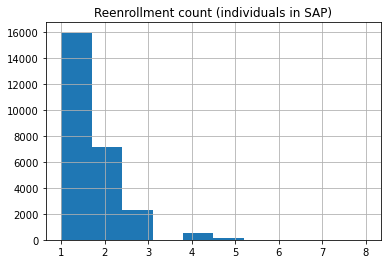

In [108]:
ds_general["count_enroll"].hist()
plt.title('Reenrollment count (individuals in SAP)')

Text(0.5, 1.0, 'Reenrollment count (individuals not in SAP)')

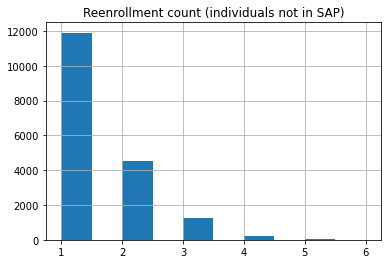

In [109]:
ds_general[(ds_general.SAP == 0)]["count_enroll"].hist()
plt.title('Reenrollment count (individuals not in SAP)')

<AxesSubplot:>

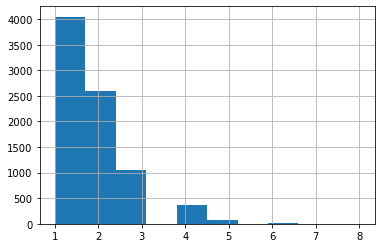

In [110]:
ds_general[(ds_general.SAP == 1)]["count_enroll"].hist()
plt.title('Reenrollment count (enrolled in SAP)')

<AxesSubplot:>

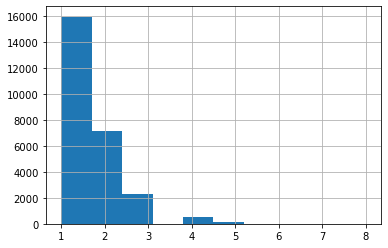

In [111]:
# loadings per week. We see outliers at 30-45
ds_general["count_enroll"].hist()

In [30]:
# Drop User_id for matching
match_all = ds_general.loc[:, ~ds_general.columns.isin(['user_id','Age'])]
match_all

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
0,Asian,Subsidized Annual Pass,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,English,2,8
1,Black or African American,Subsidized Annual Pass,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,English,3,6
2,Black or African American,NA,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,Other,English,2,6
3,Black or African American,Subsidized Annual Pass,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,King County Public Health,English,4,5
4,Hispanic or Latino,Subsidized Annual Pass,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,English,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,Black or African American,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,King County Public Health,English,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,KCMCCS,English,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,4,1
93598,White,10,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,0,1,1,2,3,0,CCS,English,3,1


In [31]:
match_all.RaceDesc.value_counts()

White                                        8855
Black or African American                    5209
Asian                                        4057
Hispanic or Latino                           2656
Not Specified                                2429
Other                                        1556
American Indian or Alaska Native              647
Multi-Racial                                  349
Native Hawaiian or Other Pacific Islander     314
Name: RaceDesc, dtype: int64

## Mapping categorical variables to ordinal values for FLAME.

In [32]:
# Map all string categorical variables to numbers.
race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
match_all['RaceDesc'] = match_all['RaceDesc'].map(race)
match_all
# df_trunc['rf_phyp'] = df_trunc['rf_phyp'].map(d)

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
0,2,Subsidized Annual Pass,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,English,2,8
1,1,Subsidized Annual Pass,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,English,3,6
2,1,NA,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,Other,English,2,6
3,1,Subsidized Annual Pass,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,King County Public Health,English,4,5
4,3,Subsidized Annual Pass,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,English,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,1,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,King County Public Health,English,0,1
93563,0,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,KCMCCS,English,2,1
93572,0,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,4,1
93598,0,10,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,0,1,1,2,3,0,CCS,English,3,1


In [33]:
language = {"English": 0, "Chinese": 1, "Spanish": 2, "Dari": 3, "Vietnamese": 4, 'Other': 5}
match_all['Language'] = match_all['Language'].map(language)
match_all

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
0,2,Subsidized Annual Pass,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,0,2,8
1,1,Subsidized Annual Pass,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,0,3,6
2,1,NA,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,Other,0,2,6
3,1,Subsidized Annual Pass,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,King County Public Health,0,4,5
4,3,Subsidized Annual Pass,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,1,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,King County Public Health,0,0,1
93563,0,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,KCMCCS,0,2,1
93572,0,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),0,4,1
93598,0,10,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,0,1,1,2,3,0,CCS,0,3,1


In [48]:
a = {"King County Public Health": 0, "DSHS - ORCA LIFT (remote enrollment)": 1, "DSHS - subsidized annual pass (remote enrollment)": 2, "CCS": 3, "KCMCCS": 4, 'Other': 5}
match_all['Agency'] = match_all['Agency'].map(a)
match_all

,RaceDesc,Initial_Load,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,SAP,Agency,Language,Age_bin,count_enroll
0,2,1,3,3,3,3,2,1,3,0,2,8
1,1,1,3,3,3,3,2,1,3,0,3,6
2,1,2,3,3,3,3,2,0,5,0,2,6
3,1,1,3,3,3,3,2,1,0,0,4,5
4,3,1,3,3,3,3,2,1,3,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
26067,1,2,2,0,0,0,0,0,0,0,0,1
26068,0,0,0,2,0,0,3,0,4,0,2,1
26069,0,0,0,0,0,0,1,0,1,0,4,1
26070,0,0,0,0,0,0,1,0,3,0,3,1


In [39]:
a = {"10": 0, "Subsidized Annual Pass": 1, "NA": 2, "70": 3, "20": 4, '50': 5,  '15': 6, 'Misc. Pass':7, '30': 8, 'Passport': 9 }
match_all['Initial_Load'] = match_all['Initial_Load'].map(a)
match_all

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
0,2,1,61080,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,0,2,8
1,1,1,107444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,0,3,6
2,1,2,57528,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,Other,0,2,6
3,1,1,10168,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,King County Public Health,0,4,5
4,3,1,172698,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,CCS,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93559,1,2,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,King County Public Health,0,0,1
93563,0,0,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,KCMCCS,0,2,1
93572,0,0,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),0,4,1
93598,0,0,39120,0.400939,239,0.005537,0.005537,Seattle,0.065562,0,...,0,1,1,2,3,0,CCS,0,3,1


In [38]:
match_all['Initial_Load'].value_counts()

10                        15898
Subsidized Annual Pass     8173
NA                         1619
70                          155
20                           76
50                           72
15                           39
Misc. Pass                   31
30                            5
Passport                      4
Name: Initial_Load, dtype: int64

In [40]:
# match_all.to_csv('/Users/JennyH/cisil-causal-inference/Data/flame_enrollment2.csv')  

# FLAME Algorithm For Matching (Starts Here if you have flame_enrollment3.csv)

In [53]:
match_all = pd.read_csv("/Users/JennyH/cisil-causal-inference/Data/flame_enrollment3.csv")
match_all = match_all.loc[:, ~match_all.columns.isin(['Unnamed: 0'])]
match_all

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,1,3,3,3,3,3,2,3,0,2
1,1,0,1,3,3,3,3,2,5,0,2
2,1,1,2,3,3,3,3,2,3,0,3
3,0,0,1,3,3,3,3,2,3,0,4
4,1,1,2,3,3,3,3,2,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...
26041,8,0,1,0,0,2,0,0,0,0,0
26042,2,0,1,0,2,0,0,3,4,0,0
26043,0,1,1,0,1,0,1,2,2,0,3
26044,0,1,1,3,0,1,1,0,2,0,2


In [54]:
match_all = match_all.loc[:, ~match_all.columns.isin(['id', 'OverallJobAccess', 'lowwagelaborforce', 'Access30Transit', 'Access30Transit_ts', 'MSA', 'spatialmismatch'])]
match_all

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,1,3,3,3,3,3,2,3,0,2
1,1,0,1,3,3,3,3,2,5,0,2
2,1,1,2,3,3,3,3,2,3,0,3
3,0,0,1,3,3,3,3,2,3,0,4
4,1,1,2,3,3,3,3,2,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...
26041,8,0,1,0,0,2,0,0,0,0,0
26042,2,0,1,0,2,0,0,3,4,0,0
26043,0,1,1,0,1,0,1,2,2,0,3
26044,0,1,1,3,0,1,1,0,2,0,2


In [49]:
# Remove Decile quantiles for now.
match_all = match_all.loc[:, ~match_all.columns.isin([
    'OverallJobAccess_quantileNum_10q', 'lowwagelaborforce_quantileNum_10q', 
    'Access30Transit_quantileNum_10q', 'Access30Transit_ts_quantileNum_10q', 
    'spatialmismatch_quantileNum_10q'])]


In [55]:
match_all

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,1,3,3,3,3,3,2,3,0,2
1,1,0,1,3,3,3,3,2,5,0,2
2,1,1,2,3,3,3,3,2,3,0,3
3,0,0,1,3,3,3,3,2,3,0,4
4,1,1,2,3,3,3,3,2,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...
26041,8,0,1,0,0,2,0,0,0,0,0
26042,2,0,1,0,2,0,0,3,4,0,0
26043,0,1,1,0,1,0,1,2,2,0,3
26044,0,1,1,3,0,1,1,0,2,0,2


# Run Matching Using FLAME

In [56]:
# flame is faster but dame considers more covariate sets. stopping upon matching all t'ed units.
model_flame_AMT = dame_flame.matching.FLAME(repeats=False, 
                                            verbose=3, 
                                            early_stop_iterations=30, 
                                            stop_unmatched_t = True, 
                                            adaptive_weights='decisiontreeCV', 
                                            alpha=0.5, 
                                            want_pe=True)

In [57]:
model_flame_AMT.fit(holdout_data=False, treatment_column_name='SAP', outcome_column_name='count_enroll')
result_flame_AMT = model_flame_AMT.predict(match_all)

Iteration number:  1
	Number of matched groups formed in total:  1091
	Unmatched treated units:  5337 out of a total of  8172 treated units
	Unmatched control units:  13850 out of a total of  17874 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  6859
	Number of matches made so far:  6859
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  1707
	Unmatched treated units:  3789 out of a total of  8172 treated units
	Unmatched control units:  11215 out of a total of  17874 control units
	Predictive error of covariates chosen this iteration:  0.5472721319454528
	Number of matches made in this iteration:  4183
	Number of matches made so far:  11042
	In this iteration, the covariates dropped are:  Age_bin
Iteration number:  3
	Number of matched groups formed in total:  2545
	Unmatched treated units:  635 out of a total of  8172 treated units
	Unmatched contro

In [ ]:
flame_enrollment2.csv
Unmatched treated units:  0 out of a total of  8173 treated units
Unmatched control units:  136 out of a total of  17899 control units

flame_enrollment3.csv
Unmatched treated units:  0 out of a total of  8172 treated units
Unmatched control units:  1354 out of a total of  17874 control units

### Create Figure Displaying Match Group Size vs. Covariates Matched.

<ipython-input-16-9d330d07b181>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=x, rotation=90)


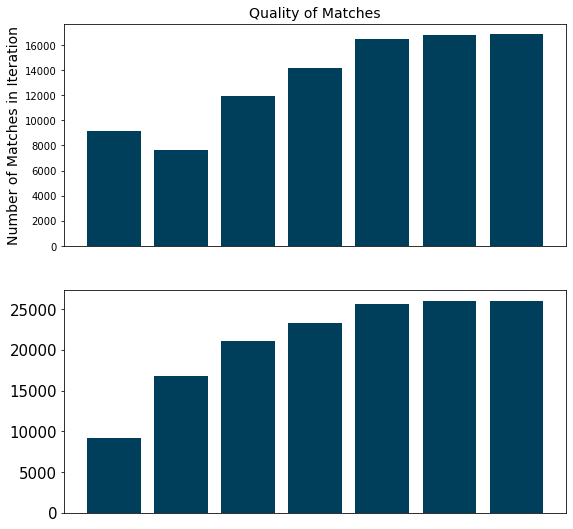

In [16]:
x = ["NONE", "AGENCY", '+AGE', '+RACE', '+Language', '+Access30Transit', '+lowwagelaborforce']
y1 = [9130, 7614, 11950, 14126, 16455, 16815, 16854] 
y2 = [9130, 16744, 21080, 23256, 25585, 25945, 25984]


f, ax = plt.subplots(ncols = 1, nrows = 2, gridspec_kw = {'width_ratios':[.51]}, figsize=(9,9))
ax[0].set_ylabel('Number of Matches in Iteration', fontsize=14)
ax[0].set_xticklabels(labels=x, rotation=90)
ax[0].set_xlabel('Covariate(s) Dropped', fontsize=14)
ax[0].set_title('Quality of Matches', fontsize=14)
ax[0].bar(x,y1, color = '#003f5c')
ax[0].axes.xaxis.set_visible(False)

# ax[1].set_ylabel('Number of Matches Made', fontsize=22)
ax[1].set_xlabel('Covariate(s) Dropped', fontsize=30)
# ax[1].set_title('Quality of Matches', fontsize=30)
ax[1].bar(x,y2, color = '#003f5c')
ax[1].tick_params(axis="y", labelsize=15)
ax[1].axes.xaxis.set_visible(False)

In [17]:
# ATE Overall.
ate_AMT = dame_flame.utils.post_processing.ATE(model_flame_AMT)
ate_AMT

0.24213574534145804

In [ ]:
# As we can see, the ATE is slightly positive, 
# implying that the subsidized annual pass (SAP) causes an enroller 
# to enroll more than non-SAP recipients by this many more times.

In [21]:
group1 = model_flame_AMT.units_per_group[2]
s_mmg = match_all.loc[group1]
s_mmg # each row of group 1.

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
4011,0,0,1,3,1,1,1,0,0,0,0
4012,0,0,1,3,1,1,1,0,0,0,0
4017,0,1,2,3,1,1,1,0,0,0,0
9717,0,0,1,3,1,1,1,0,0,0,0
19312,0,0,1,3,1,1,1,0,0,0,0
23157,0,0,1,3,1,1,1,0,0,0,0
24052,0,1,1,3,1,1,1,0,0,0,0


In [22]:
s_mmg.iloc[0]["RaceDesc"] == 0 # color all group numbers of this group.

True

In [23]:
def create_df_scatter(feature, category):
    '''
    Creates a scatter plot of the size of matched group against CATE estimate.
    Note: the model name and dataframe are specified below 
    (make sure to change for different models and dataframe).
    
    feature (str): variable of interest.
    category (int): level of variable to highlight.
    '''
    group_size_overall = []
    cate_of_group = []
    in_desired_variable = []
    size_desired_group = []
    cate_desired_group = []
    

    for group in model_flame_AMT.units_per_group:

        # find len of just treated units
        df_mmg = match_all.loc[group] # chooses rows with row id in group.
        treated = df_mmg.loc[df_mmg["SAP"] == 1] # chooses the rows with treatment = 1
        desired_variable = df_mmg.iloc[0][feature] == category # true/false vector. an indicator.

        # group_size_treated.append(len(treated))
        group_size_overall.append(len(group))
        in_desired_variable.append(desired_variable)

        cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_AMT, group[0]))
        
        if desired_variable == True:
            cate_desired_group.append(dame_flame.utils.post_processing.CATE(model_flame_AMT, group[0]))
            size_desired_group.append(len(group))
        
    
    return(group_size_overall, cate_of_group, in_desired_variable, size_desired_group, cate_desired_group)


In [24]:
def create_cate_lst(sizes, cates):
    '''
    helper function to create credible interval for ATE. Creates an extended list
    where each element is the CATE for a unit.'''
    
    out = []
    for i in range(len(cates)):
        for j in range(sizes[i]):
            out.append(cates[i])
    return out 

### Creat Scatter Plots Displaying CATES of re-enrollment

In [25]:
# Calculate the quantiles for ATE.
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2)

cate_lst = create_cate_lst(size, cate_all)

0.23688244249823137 0.2473890481846826


Text(0, 0.5, 'CATE')

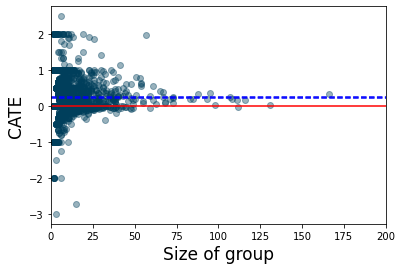

In [26]:
plt.scatter(size, cate_all, c = "#003f5c", alpha=0.4)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=mean_cate, color='b', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)
# plt.title("Visualizing Enrollment CATE of matched groups by size", fontsize=14)

plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('ate_scatter_enrollment.pdf', bbox_inches="tight")

In [27]:
# Here are the corresponding codes for race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2)

In [28]:
## Conf. Interval
## Conf. Interval for Matched groups with Asian Individuals
cate_lst = create_cate_lst(size_asian, cate_asian)

mean_cate = sum(cate_lst)/len(cate_lst)
mean_cate

0.3943904544861207 0.4252307117676056


Text(0, 0.5, 'CATE')

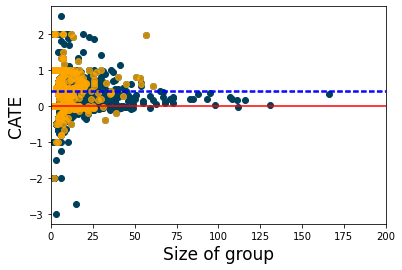

In [30]:
# Scatterplot Displaying the CATE of matched groups with Asian Individuals

cors = {True:'#bc5090', False:'#ffa600'}
asian = pd.Series(in_asian)

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_asian, cate_asian, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=mean_cate, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('asian_enroll.pdf', bbox_inches="tight")

### Scatter for AccesstoTransit

In [31]:
# Calculate the quantiles for Lowest transit Quantile.
(size, cate_all, in_trans1, size_trans1, cate_trans1) = create_df_scatter("Access30Transit_quantileNum_4q", 0)

cate_lst = create_cate_lst(size_trans1, cate_trans1)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub)  

0.16575335845133699 0.1752422040514177 0.1847310496514984


Text(0, 0.5, 'CATE')

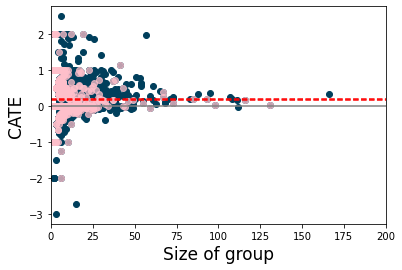

In [32]:
# Scatterplot Displaying the CATE of matched groups with transit1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_trans1, cate_trans1, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='grey', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('trans1_enroll.pdf', bbox_inches="tight")

In [33]:
# Calculate the quantiles for Highest transit quantile.
(size, cate_all, in_trans3, size_trans3, cate_trans3) = create_df_scatter("Access30Transit_quantileNum_4q", 3)

cate_lst = create_cate_lst(size_trans3, cate_trans3)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub)  

0.30439171112532726 0.31492923438392384 0.3254667576425204


Text(0, 0.5, 'CATE')

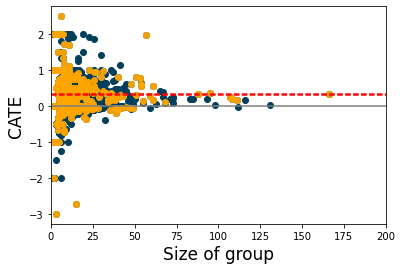

In [34]:
# Scatterplot Displaying the CATE of matched groups with transit3 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_trans3, cate_trans3, c = "#ffa600", alpha=0.95)

plt.axhline(y=0.0, color='gray', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('trans3_enroll.pdf', bbox_inches="tight")

In [43]:
# For each unit, we can see a table displaying the covariates it was matched on.
matched = model_flame_AMT.df_units_and_covars_matched
matched[:10]

,RaceDesc,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,3,3,3,3,2,*,0,*
1,1,3,3,3,3,2,*,0,*
2,1,3,3,3,3,2,3,0,3
3,0,3,3,3,3,2,3,0,4
4,1,3,3,3,3,2,3,0,2
5,0,3,3,3,3,2,3,0,3
6,1,3,3,3,3,2,0,0,3
7,1,3,3,3,3,2,0,0,4
8,0,3,3,3,3,2,*,5,*
9,1,3,3,3,3,2,3,0,3


### Scatter for OverallJobAccess

In [38]:
# Calculate the quantiles for Lowest Overall Job Access Quantile.
(size, cate_all, in_Ja1, size_Ja1, cate_Ja1) = create_df_scatter("OverallJobAccess_quantileNum_4q", 0)

cate_lst = create_cate_lst(size_Ja1, cate_Ja1)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub) 

0.16928629364170067 0.17896728805162826 0.18864828246155585


Text(0, 0.5, 'CATE')

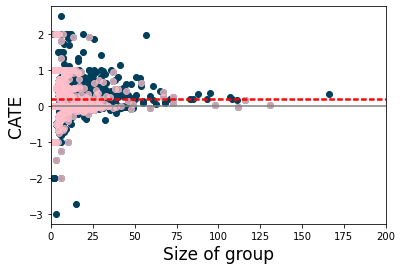

In [39]:
# Scatterplot Displaying the CATE of matched groups with Ja1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_Ja1, cate_Ja1, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='grey', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('Ja1_enroll.pdf', bbox_inches="tight")

In [40]:
# Calculate the quantiles for Highest Overall Job Access Quantile.
(size, cate_all, in_Ja3, size_Ja3, cate_Ja3) = create_df_scatter("OverallJobAccess_quantileNum_4q", 3)

cate_lst = create_cate_lst(size_Ja3, cate_Ja3)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub) 

0.3127118471222903 0.32296071470868726 0.33320958229508424


Text(0, 0.5, 'CATE')

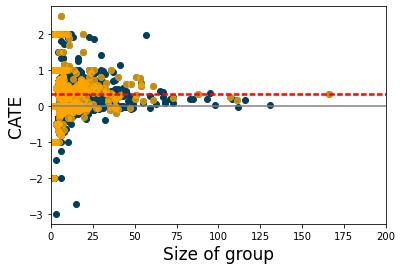

In [41]:
# Scatterplot Displaying the CATE of matched groups with Ja1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_Ja3, cate_Ja3, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='grey', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('Ja3_enroll.pdf', bbox_inches="tight")

# Exact Matching

In [6]:
# Matching on all 9 covariates in the dataset.
model_flame_EX = dame_flame.matching.FLAME(repeats=False, verbose=3, early_stop_iterations=1, stop_unmatched_t = True, adaptive_weights='decisiontree', want_pe=True)


In [7]:
model_flame_EX.fit(holdout_data=False, treatment_column_name='SAP', outcome_column_name='count_enroll')
result_flame_EX = model_flame_EX.predict(match_all)

Iteration number:  1
	Number of matched groups formed in total:  1166
	Unmatched treated units:  5187 out of a total of  9068 treated units
	Unmatched control units:  13002 out of a total of  18251 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  9130
	Number of matches made so far:  9130
	In this iteration, the covariates dropped are:  set()
9130 units matched. We stopped before doing iteration number:  1
